
# <center> Adagrad, RMSProp, and Adam algorithm


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk

class GD:
    def __init__(self , data , alpha=0.001 , acc = 0.05, batch_size=50 , max_iter = 1000 , show_line_history = False , gama = None , beta = 0.9 , beta_m = 0.9 , beta_v = 0.9 , NAG=False , Adagrad=False , epsilon = 1.0e-8 , RMSProp=False , Adam=False ):
        
        # data attributes
        self.number_of_data_points = data.shape[0]
        self.number_of_parameters  = data.shape[1]
        
        # hyper parameter 
        self.data     = data
        self.alpha    = alpha
        self.gama     = gama
        self.acc      = acc
        self.max_iter = max_iter
        self.beta_m   = beta_m
        self.beta_v   = beta_v
        self.beta     = beta
        
        self.accuracy = 0
        
        self.v = np.zeros(( self.number_of_parameters , 1))
        self.epsilon = epsilon
        
        
        # batch size attributes
        if batch_size == None: self.batch_size = self.number_of_data_points
        else:self.batch_size = batch_size
        self.number_of_batches = number_of_data_points // self.batch_size
        
        # algorithm attributes
        self.theta      = np.zeros(self.number_of_parameters).reshape((self.number_of_parameters,1))
        self.hypothesis = ""
        self.v          = 0
        self.m          = 0
        
        # history attributes
        self.line_history  = []
        self.cost_history  = []
        self.theta_history = []
        
        # helper attributes
        self.show_line_history = show_line_history
        self.f, self.axs = plt.subplots(2,2,figsize=(15,15))
        self.counter     = 1
        
        # algorithm type attributes
        self.NAG     = NAG
        self.Adagrad = Adagrad
        self.RMSProp = RMSProp
        self.Adam    = Adam
        
        
        
        
        
    def __str__(self):
        return f'''
        ==================================================================================================
        data summery--------------------------
        
                data shape             : {self.data.shape}
                number of DP           : {self.number_of_data_points}
                number of arguments    : {self.number_of_parameters}
        
        hyper parameter-----------------------
                
                alpha                  : {self.alpha}
                gama                   : {self.gama}
                batch size             : {self.batch_size}
                number of batches      : {self.number_of_batches}
                Momentum-based GD      : {self.gama != None}
                Nesterov Accelerated GD: {self.NAG}
                Adagrad GD             : {self.Adagrad}
                RMSProp GD             : {self.RMSProp}
                Adam GD                : {self.Adam}
        
        output ----------------------------
                
                hypothesis             : {self.hypothesis}
                accuracy               : {self.accuracy}
        ==================================================================================================
        ''' 
    
    def printData(self):
        print(self.data)
        
    def prepareData(self):
        ones_column = np.ones(self.number_of_data_points).reshape((self.number_of_data_points , 1))
        features = np.concatenate((ones_column,self.data[:,:-1]) , axis = 1)
        labels   = (self.data[:,-1]).reshape((self.number_of_data_points , 1))
        return (features , labels)
    
    def initializeThetasRandomly(self):
        for i in range(self.number_of_parameters):
            self.theta[i,0] = np.random.random()
    
        
    def hypo(self, x):
        h = x @ self.theta
        return h
        
    def cost(self , x , y):
        m = x.shape[0]
        h = self.hypo(x)
        J = (1/(2*m))  * np.sum((h-y)**2)
        return J
    
    def grad(self , x , y):
        m = x.shape[0]
        h = self.hypo(x)
        g = ((1/m) * ((h-y).T @ x)).T
        return g
    
    def updateThetasWithNesterov(self , x , y):
        
        theta_temp = self.theta - (self.gama * self.v)
        grad = self.grad(x , y)
        self.theta = self.theta - (self.alpha * grad)
        
        self.v = self.gama * self.v + self.alpha * grad
        
    
    def updateThetasWithMomentum(self , grad):
        self.v = (self.gama * self.v) + (self.alpha * grad)
        self.theta = self.theta - self.v
    
    def updateThetas(self , grad):
        self.theta = self.theta - (self.alpha * grad)
        
    def counterStop(self):
        if(self.counter >= self.max_iter):return True
        return False
    
    def gradStop(self , grad):
        if(abs(np.sum(grad)) <= self.acc): return True
        return False
        
    def updateThetasWithAdagrad(self , grad):
        self.v = self.v + (np.power(grad , 2))
#         print(self.v)
        self.theta = self.theta - ((self.alpha / (np.sqrt(self.v) + self.epsilon)) * grad)
        
    def updateThetasWithRMSProp(self , grad):
        self.v = (self.beta * self.v) + ((1-self.beta) * (grad ** 2))
        self.theta    = self.theta - (self.alpha / (np.sqrt(self.v) + self.epsilon)) * grad
        
        
    def updateThetasWithAdam(self , grad):
        self.m = (self.beta_m * self.m) + ((1-self.beta_m)* grad)
        self.v = (self.beta_v * self.v) + ((1-self.beta_v)*(np.power(grad , 2)))
        
        self.m = (self.m) / (1 - np.power(self.beta_m , self.counter))
        self.v = (self.v) / (1 - np.power(self.beta_v , self.counter))
        
        self.theta = self.theta - ((self.alpha / (np.sqrt(self.v) + self.epsilon)) * grad)
        
    
    def fit(self):
        x , y = self.prepareData();
        
        self.initializeThetasRandomly()
        
        idx = list(range(0,self.number_of_data_points+1 , self.batch_size))
        grad   = self.grad(x , y)
        
        
        while (self.gradStop(grad) == False) and (self.counterStop() == False) :
            for i in range(self.number_of_batches):
                
                mini_x =  x[ idx[i] : idx[i+1] , : ] 
                mini_y =  y[ idx[i] : idx[i+1] , : ]
                grad   = self.grad(mini_x , mini_y)

                
                if  (self.NAG     == True): 
                    self.updateThetasWithNesterov(mini_x , mini_y)  
                    if(self.counter == 1): print("updating with NAG")
                elif(self.Adagrad == True): 
                    self.updateThetasWithAdagrad   (grad)             
                    if(self.counter == 1): print("updating with Adagrad")
                elif(self.RMSProp == True): 
                    self.updateThetasWithRMSProp   (grad)             
                    if(self.counter == 1): print("updating with RMSProb")
                elif(self.Adam    == True): 
                    self.updateThetasWithAdam      (grad)             
                    if(self.counter == 1): print("updating with Adam")
                elif(self.gama    == None): 
                    self.updateThetas(grad)            
                    if(self.counter == 1): print("updating with momentum")
                else                      : 
                    self.updateThetasWithMomentum  (grad)             
                    if(self.counter == 1): print("updating with Gradiant Descent")
                
                
                if(self.show_line_history):self.axs[0,0].plot(x , self.hypo(x) , alpha=0.2)
                
                self.cost_history.append(self.cost(mini_x , mini_y))
                self.theta_history.append([self.theta[0,0] , self.theta[1,0]])
            self.counter += 1
            if (self.counter % (self.max_iter // 30) == 0):
                print(f"\tepoch #{self.counter} accuracy\t: {round(self.calculateAccurecy(y , self.hypo(x))*100 , 3)} \t gradiant \t: {abs(np.sum(grad))}")
        
        print(f"done\n\tepoch #{self.counter} accuracy\t: {round(self.calculateAccurecy(y , self.hypo(x))*100 , 3)} \t gradiant \t: {abs(np.sum(grad))}")
        
        self.theta_history = np.array (self.theta_history)
        self.accuracy = self.calculateAccurecy(mini_y , self.hypo(mini_x))*100
        self.hypothesis = self.model()
    
    def predict(self , x):
        ones_column = np.ones(x.shape[0]).reshape((x.shape[0] , 1))
        new_x       = np.concatenate((ones_column,x) , axis = 1)
        h           = self.hypo(new_x)
        return h
        
    def graphs(self):
        self.axs[0,0].title.set_text("best fit line")
        self.axs[0,0].set_xlabel("input")
        self.axs[0,0].set_ylabel("output")
        self.axs[0,0].plot(xi , self.predict(xi) , c='r')
        self.axs[0,0].scatter(self.data[:,0] , self.data[:,1])
        
        self.axs[0,1].title.set_text("optimizing cost function")
        self.axs[0,1].set_xlabel("iteration number")
        self.axs[0,1].set_ylabel("cost function")
        self.axs[0,1].plot(self.cost_history[:100] ,  marker="o")
        
        self.axs[1,0].set_xlabel("theta 0")
        self.axs[1,0].set_ylabel("cost")
        self.axs[1,0].title.set_text("optimizing parameter")
        self.axs[1,0].plot(model.theta_history[:,0] , model.cost_history[:] , marker="o")
        
        
        self.axs[1,1].set_xlabel("theta 1")
        self.axs[1,1].set_ylabel("cost")
        self.axs[1,1].title.set_text("optimizing parameter")
        self.axs[1,1].plot(model.theta_history[:,1] , model.cost_history[:] , marker="o")
        
    def model(self):
        result  = ""
        for i in range (self.number_of_parameters-1):
            result += f"{round(self.theta[i+1,0] , 3)} * "
            result += "x"+str(i+1) + " + "
        result += f"{round(self.theta[0,0] , 3)}"
        return result
        
    def calculateAccurecy(self , y_true , y_pred):
        return sk.r2_score(y_true , y_pred)

In [ ]:
number_of_data_points = 100
a ,b = -2 , 1

np.random.seed()
xi = (np.random.random(number_of_data_points)*20).reshape((number_of_data_points,1))
yi = (a*xi + b)
data = np.concatenate((xi , yi) , axis= 1)


# <center>Adagrad</center>

updating with Adagrad
	epoch #33 accuracy	: -70.084 	 gradiant 	: 167.09219008216905
	epoch #66 accuracy	: 12.192 	 gradiant 	: 119.35472124744604
	epoch #99 accuracy	: 50.823 	 gradiant 	: 88.6907109381153
	epoch #132 accuracy	: 71.335 	 gradiant 	: 66.98633403369784
	epoch #165 accuracy	: 82.799 	 gradiant 	: 51.00656050785622
	epoch #198 accuracy	: 89.374 	 gradiant 	: 39.01105567305158
	epoch #231 accuracy	: 93.2 	 gradiant 	: 29.912312730706287
	epoch #264 accuracy	: 95.446 	 gradiant 	: 22.970528649922482
	epoch #297 accuracy	: 96.774 	 gradiant 	: 17.656674613798497
	epoch #330 accuracy	: 97.563 	 gradiant 	: 13.581077519868659
	epoch #363 accuracy	: 98.036 	 gradiant 	: 10.45162145505439
	epoch #396 accuracy	: 98.322 	 gradiant 	: 8.047028757584844
	epoch #429 accuracy	: 98.498 	 gradiant 	: 6.198643283214241
	epoch #462 accuracy	: 98.608 	 gradiant 	: 4.777445781468361
	epoch #495 accuracy	: 98.68 	 gradiant 	: 3.684524829108282
	epoch #528 accuracy	: 98.729 	 gradiant 	: 2.84

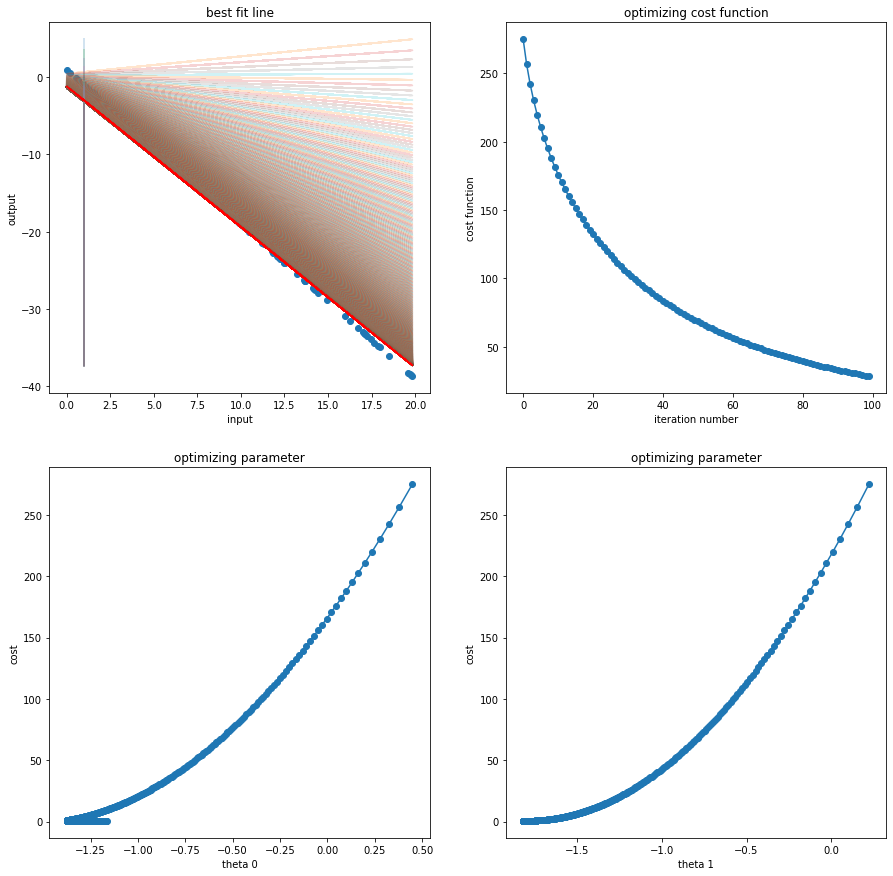

In [ ]:
model = GD(data , Adagrad=True ,  batch_size=100 , acc=1e-5 ,alpha = 0.1 , max_iter=1000 , show_line_history=True , epsilon=1e-8); model.fit(); model.graphs(); print(model)

# <center>RMSProb</center>

updating with RMSProb
	epoch #33 accuracy	: -471.012 	 gradiant 	: 304.7399597341357
	epoch #66 accuracy	: -321.067 	 gradiant 	: 261.6681916578539
	epoch #99 accuracy	: -195.443 	 gradiant 	: 219.14928515540876
	epoch #132 accuracy	: -93.08 	 gradiant 	: 177.05562742664932
	epoch #165 accuracy	: -13.63 	 gradiant 	: 135.5759221469155
	epoch #198 accuracy	: 43.422 	 gradiant 	: 95.08386016486563
	epoch #231 accuracy	: 79.002 	 gradiant 	: 56.416081141160184
	epoch #264 accuracy	: 95.169 	 gradiant 	: 22.026722974220753
	epoch #297 accuracy	: 98.183 	 gradiant 	: 1.7005495877376575
	epoch #330 accuracy	: 98.618 	 gradiant 	: 0.5159036251347671
	epoch #363 accuracy	: 98.947 	 gradiant 	: 0.5506363612563487
	epoch #396 accuracy	: 99.215 	 gradiant 	: 0.570782734134412
	epoch #429 accuracy	: 99.459 	 gradiant 	: 1.0096348178756258
	epoch #462 accuracy	: 99.648 	 gradiant 	: 0.3280768680444064
	epoch #495 accuracy	: 99.795 	 gradiant 	: 0.8403414747087377
	epoch #528 accuracy	: 99.898 	 gra

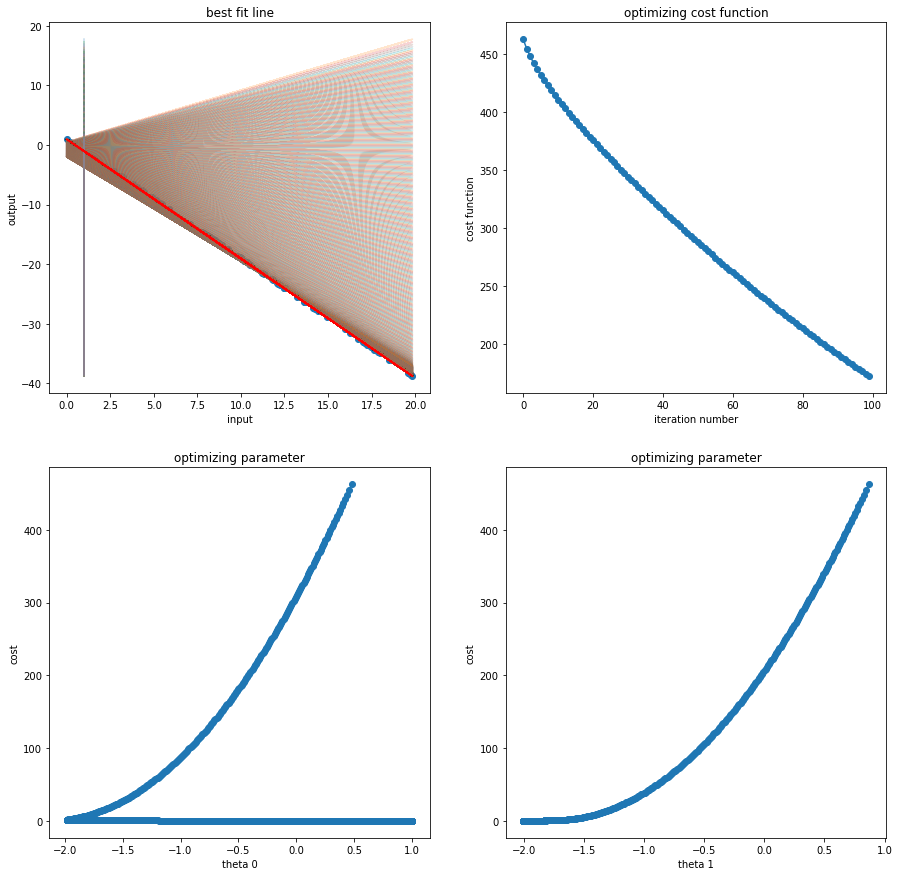

In [ ]:
model = GD(data , RMSProp=True ,  batch_size=100 , acc=1e-6 ,alpha = 0.01 ,   max_iter=1000 , show_line_history=True , beta=0.9 ,  epsilon=1e-8); model.fit(); model.graphs(); print(model)

# <center>Adam</center>

updating with Adam
	epoch #33 accuracy	: -694.628 	 gradiant 	: 358.02325650626966
	epoch #66 accuracy	: -685.173 	 gradiant 	: 355.98294762802726
	epoch #99 accuracy	: -637.306 	 gradiant 	: 345.4294696011161
	epoch #132 accuracy	: -502.908 	 gradiant 	: 312.90227354215557
	epoch #165 accuracy	: -351.303 	 gradiant 	: 270.74318335759574
	epoch #198 accuracy	: -220.796 	 gradiant 	: 228.1876986951611
	epoch #231 accuracy	: -113.501 	 gradiant 	: 185.993682658696
	epoch #264 accuracy	: -29.197 	 gradiant 	: 144.3602318697698
	epoch #297 accuracy	: 32.576 	 gradiant 	: 103.61095091089594
	epoch #330 accuracy	: 72.623 	 gradiant 	: 64.43852520424788
	epoch #363 accuracy	: 92.643 	 gradiant 	: 28.73993989075364
	epoch #396 accuracy	: 97.556 	 gradiant 	: 4.030045657593716
	epoch #429 accuracy	: 98.154 	 gradiant 	: 0.536809242857663
	epoch #462 accuracy	: 98.542 	 gradiant 	: 0.6406071695346144
	epoch #495 accuracy	: 98.877 	 gradiant 	: 0.511762501353459
	epoch #528 accuracy	: 99.164 	 gr

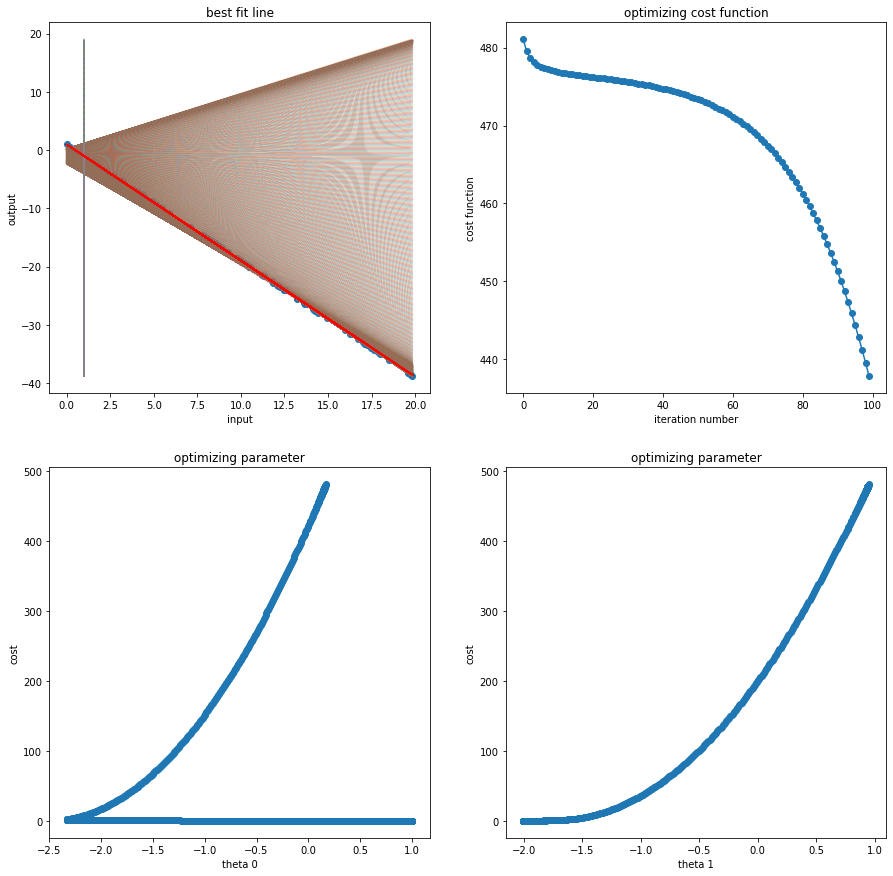

In [ ]:
model = GD(data , Adam=True ,  batch_size=100 , acc=1e-6 ,alpha = 0.01 ,   max_iter=1000 , show_line_history=True ,beta_m=0.98 , beta_v=0.9 ,  epsilon=1e-8); model.fit(); model.graphs(); print(model)